# Построение модели кредитного скоринга
Предположим, банк запускает новую программу кредитных карт с низкими процентами по кредиту и многочисленными скидками и кэш-беком у магазинов-партнеров. При этом банку важно отбирать клиентов с хорошей кредитной историей, которые с малой вероятностью потерпят дефолт.

Для отбора клиентов построим анкету, где клиент введет свои данные и система на их основе сделает вывод, стоит ли предоставлять данному клиенту услуги по новой программе, или стоит предложить ему более безопасные для банка варианты кредитных программ.

Для того, чтобы повысить конверсию анкеты, необходимо сделать ее максимально простой и быстрой для заполнения. Поэтому нам нужно будет отобрать наиболее простые и при этом значимые признаки, чтобы метрики модели оставались высокими.

Итак, начнем строить нашу модель.

Содержание
1. Импорт библиотек
2. Загрузка данных
3. Разведочный анализ данных
    - О таблицах
    - Описание полей `application_data`
    - Исследование признаков `application_data`
    - Исследование `default_data`
4. Подготовка данных
5. Обучение модели
6. Выделение наиболее важных признаков
7. Обучение модели на новых признаках
8. Оценка результатов

## Импорт библиотек

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path

sns.set_style("darkgrid")

## Загрузка данных

In [3]:
project_dir = Path.cwd()
application_data = pd.read_csv(project_dir / "data/application_info.csv", index_col="id")
default_data = pd.read_csv(project_dir / "data/default_flg.csv", index_col="id")

print(f"{application_data.shape=}, {default_data.shape=}")

application_data.shape=(205296, 18), default_data.shape=(180816, 1)


## Разведочный анализ данных

### О таблицах
**application_data** - таблица признаков. Содержит в себе сохраненные анкетные данные клиентов. Кроме этого, данная таблица содержит столбец `sample_cd`, который отмечает, к какой выборке относится данная запись - `train`, `valid` или `test`
<br>**default_data** - вектор меток. Содержи в себе информацию о наличии дефолта у клиента. Информация о дефолте представлена только для `train` и `valid` выборок, в чем мы убедимся позже, когда изучим наши данные.

### Описание полей application_data
- `id` - Анонимизированный идентификатор заявителя
- `application_dt` - Дата подачи заявки
- `sample_cd` - Категория выборки
- `education_cd` - Образование
- `gender_cd` - Пол
- `age` - Возраст
- `car_own_flg` - Флаг наличия автомобиля
- `car_type_flg` - Флаг наличия иномарки
- `appl_rej_cnt` - Количество отказанных прошлых заявок
- `good_work_flg` - Флаг наличия "хорошей" работы
- `Score_bki` - Скор балл по данным из бюро кредитных историй
- `out_request_cnt` - Количество запросов в бюро
- `region_rating` - Рейтинг региона
- `home_address_cd` - Категоризатор домашнего адреса
- `work_address_cd` - Категоризатор рабочего адреса
- `income` - Доход заявителя
- `SNA` - Связь заявителя с клиентами
- `first_time_cd` - Давность наличия информации о заявителе
- `Air_flg` - Наличие загран паспорта
- `default_flg` - Флаг дефолта по кредиту

In [4]:
application_data.head()

,application_dt,sample_cd,education_cd,gender_cd,age,car_own_flg,car_type_flg,appl_rej_cnt,good_work_flg,Score_bki,out_request_cnt,region_rating,home_address_cd,work_address_cd,income,SNA,first_time_cd,Air_flg
id,,,,,,,,,,,,,,,,,,
1,01JAN2014,train,SCH,M,27,Y,Y,0,0,-1.917831,0,40,2,3,32000,1,4,N
2,01JAN2014,train,GRD,F,26,N,N,0,0,-1.153144,2,60,2,3,50000,2,1,N
3,01JAN2014,train,SCH,M,35,N,N,0,1,-1.732810,0,40,1,2,20000,4,3,N
4,01JAN2014,train,GRD,F,35,N,N,0,1,-2.552133,2,20,2,3,80000,1,3,N
5,01JAN2014,train,UGR,F,24,N,N,0,0,-1.914581,1,50,2,3,27000,1,2,N


In [5]:
application_data.columns

Index(['application_dt', 'sample_cd', 'education_cd', 'gender_cd', 'age',
       'car_own_flg', 'car_type_flg', 'appl_rej_cnt', 'good_work_flg',
       'Score_bki', 'out_request_cnt', 'region_rating', 'home_address_cd',
       'work_address_cd', 'income', 'SNA', 'first_time_cd', 'Air_flg'],
      dtype='object')

In [6]:
application_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 205296 entries, 1 to 205296
Data columns (total 18 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   application_dt   205296 non-null  object 
 1   sample_cd        205296 non-null  object 
 2   education_cd     204384 non-null  object 
 3   gender_cd        205296 non-null  object 
 4   age              205296 non-null  int64  
 5   car_own_flg      205296 non-null  object 
 6   car_type_flg     205296 non-null  object 
 7   appl_rej_cnt     205296 non-null  int64  
 8   good_work_flg    205296 non-null  int64  
 9   Score_bki        205296 non-null  float64
 10  out_request_cnt  205296 non-null  int64  
 11  region_rating    205296 non-null  int64  
 12  home_address_cd  205296 non-null  int64  
 13  work_address_cd  205296 non-null  int64  
 14  income           205296 non-null  int64  
 15  SNA              205296 non-null  int64  
 16  first_time_cd    205296 non-null  int64  
 

Наблюдаем, что отсутствуют некоторые значения для признака `education_cd`. Также видим, что некоторые из признаков - категориальные. Учтем это при подготовке данных для обучения модели

In [7]:
application_data.describe().T

,count,mean,std,min,25%,50%,75%,max
age,205296.0,39.354566,11.451011,21.000000,30.000000,37.000000,48.000000,72.000000
appl_rej_cnt,205296.0,0.277297,0.782794,0.000000,0.000000,0.000000,0.000000,33.000000
good_work_flg,205296.0,0.169701,0.375371,0.000000,0.000000,0.000000,0.000000,1.000000
Score_bki,205296.0,-1.967120,0.488055,-3.624586,-2.313894,-1.990599,-1.641914,0.199773
out_request_cnt,205296.0,2.015826,2.138564,0.000000,1.000000,2.000000,3.000000,53.000000
region_rating,205296.0,57.332340,13.262627,20.000000,50.000000,50.000000,70.000000,80.000000
home_address_cd,205296.0,1.602218,0.520577,1.000000,1.000000,2.000000,2.000000,3.000000
work_address_cd,205296.0,2.520210,0.689453,1.000000,2.000000,3.000000,3.000000,3.000000
income,205296.0,42251.807610,45183.110679,1000.000000,20000.000000,30000.000000,50000.000000,1000000.000000
SNA,205296.0,1.725864,1.115876,1.000000,1.000000,1.000000,2.000000,4.000000


In [8]:
application_data.describe(include=["object"])

,application_dt,sample_cd,education_cd,gender_cd,car_own_flg,car_type_flg,Air_flg
count,205296,205296,204384,205296,205296,205296,205296
unique,333,3,5,2,2,2,2
top,18MAR2014,train,SCH,F,N,N,N
freq,1491,110148,100234,117400,139119,166471,172168


### Исследования признаков `application_data`
Рассмотрим распределения признаков в `application_data`.

1. `id` - Анонимизированный идентификатор заявителя.
<br>Проверим, что каждое значение идентификатора уникально

In [9]:
id_match = application_data.shape[0]==application_data.index.nunique()
print(f"Совпадение числа записей ({application_data.shape[0]}) и числа уникальных идентификаторов ({application_data.index.nunique()}) -> {id_match}")

Совпадение числа записей (205296) и числа уникальных идентификаторов (205296) -> True


2. `application_dt` - Дата подачи заявки.
<br>Проверим распределение данного признака


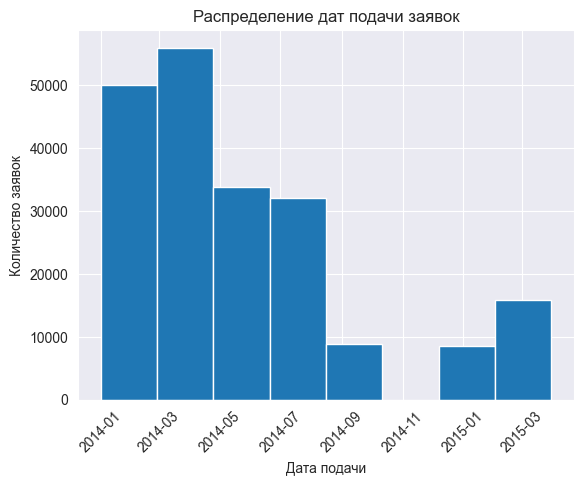

In [10]:
application_dt = pd.to_datetime(application_data["application_dt"], format="%d%b%Y").sort_values()
plt.hist(application_dt, bins=8)
plt.xticks(rotation=45)
plt.title("Распределение дат подачи заявок")
plt.ylabel("Количество заявок")
plt.xlabel("Дата подачи")
plt.show()

3. `sample_cd` - Категория выборки
<br>Проверим распределение значений данного признака

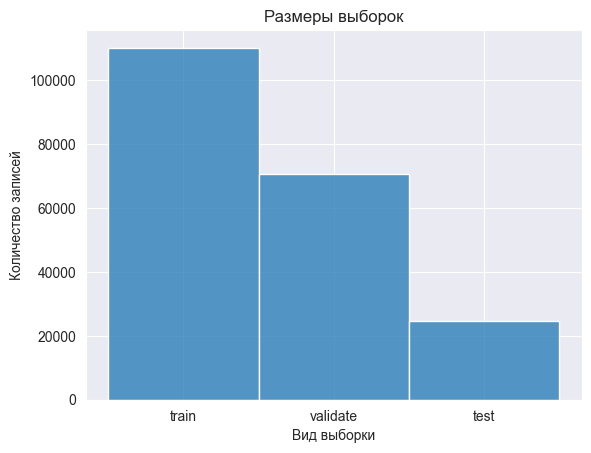

In [11]:
sns.histplot(application_data["sample_cd"])
plt.title("Размеры выборок")
plt.ylabel("Количество записей")
plt.xlabel("Вид выборки")
plt.show()

4. `education_cd` - Образование
<br>Проверим распределение значений данного признака

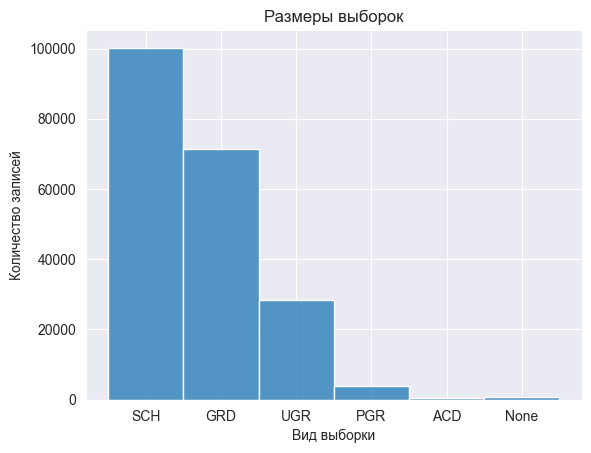

In [12]:
sns.histplot(application_data["education_cd"].fillna(value="None", inplace=False)) # Пока не будем изменять наши данные
plt.title("Размеры выборок")
plt.ylabel("Количество записей")
plt.xlabel("Вид выборки")
plt.show()

Для данного признака:
- `SCH` — School (школьное образование, среднее или ниже).
- `GRD` — Graduate (выпускник, оконченное среднее или профессиональное образование).
- `UGR` — Undergraduate (студент или уровень бакалавриата, неполное высшее).
- `PGR` — Postgraduate (магистратура, аспирантура, уровень выше бакалавриата).
- `ACD` — Academic (учёная степень, например PhD или эквивалент).
- `None` — отсутствующее значение (нет данных о человеке, пропуск в записи или у человека просто нет образования).

5. `gender_cd` - Пол
<br>Проверим распределение значений данного признака

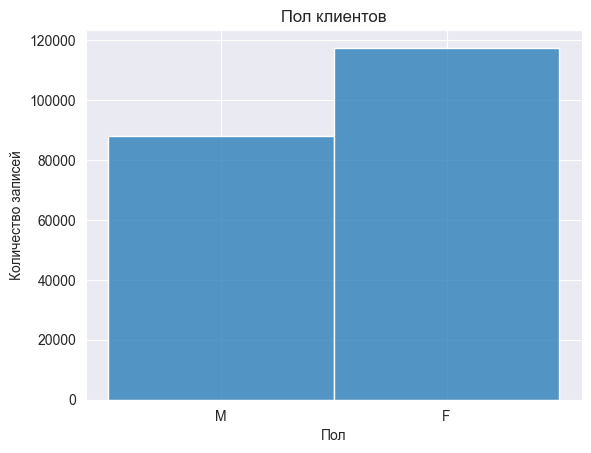

In [13]:
sns.histplot(application_data["gender_cd"])
plt.title("Пол клиентов")
plt.ylabel("Количество записей")
plt.xlabel("Пол")
plt.show()

6. `age` - Возраст
<br>Проверим распределение значений данного признака

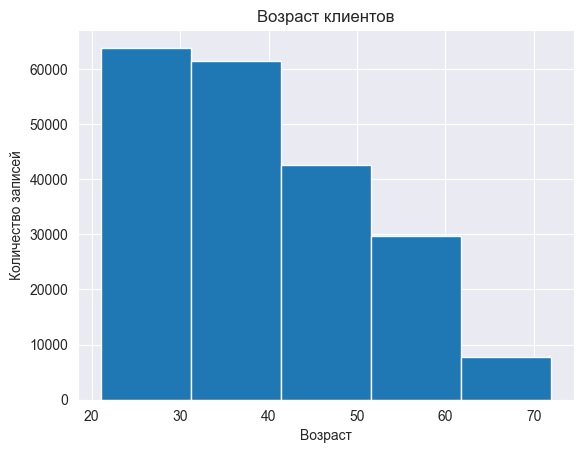

In [14]:
plt.hist(application_data["age"], bins=5)
plt.title("Возраст клиентов")
plt.ylabel("Количество записей")
plt.xlabel("Возраст")
plt.show()

7. `car_own_flg` - Флаг наличия автомобиля
<br>Проверим распределение значений данного признака

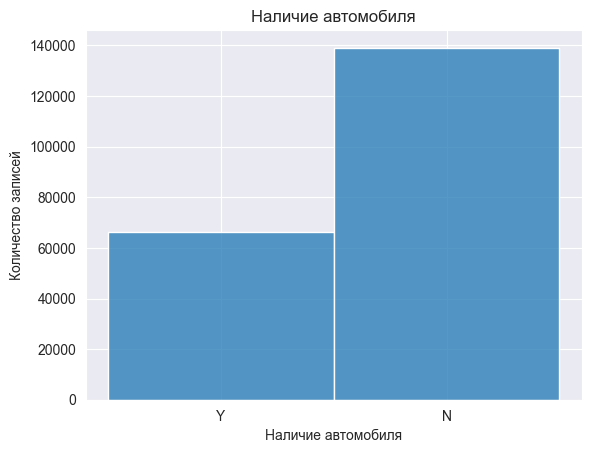

In [15]:
sns.histplot(application_data["car_own_flg"])
plt.title("Наличие автомобиля")
plt.ylabel("Количество записей")
plt.xlabel("Наличие автомобиля")
plt.show()

8. `car_type_flg` - Флаг наличия иномарки
<br>Проверим распределение значений данного признака

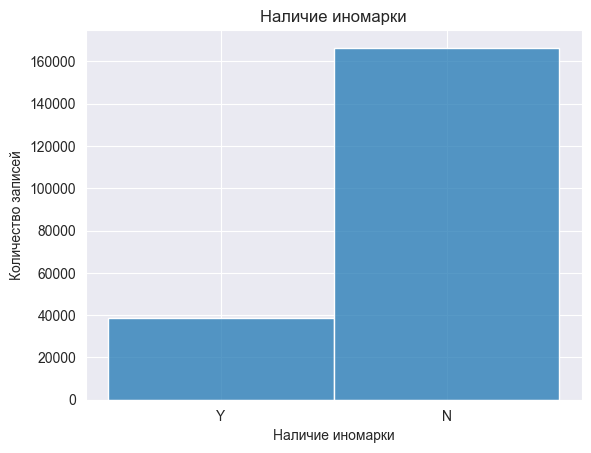

In [16]:
sns.histplot(application_data["car_type_flg"])
plt.title("Наличие иномарки")
plt.ylabel("Количество записей")
plt.xlabel("Наличие иномарки")
plt.show()

9. `appl_rej_cnt` - Количество отказанных прошлых заявок
<br>Проверим распределение значений данного признака

In [17]:
application_data["appl_rej_cnt"].value_counts().sort_index().to_frame()

,count
appl_rej_cnt,
0,169284
1,24413
2,6954
3,2507
4,1085
5,471
6,284
7,113
8,71


10. `good_work_flg` - Флаг наличия "хорошей" работы
<br>Проверим распределение значений данного признака

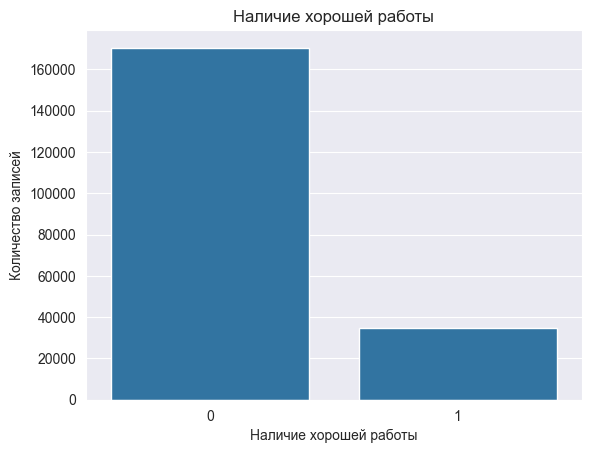

In [24]:
sns.barplot(application_data["good_work_flg"].value_counts())
plt.title("Наличие хорошей работы")
plt.ylabel("Количество записей")
plt.xlabel("Наличие хорошей работы")
plt.show()

11. `Score_bki` - Скор балл по данным из бюро кредитных историй
<br>Проверим распределение значений данного признака

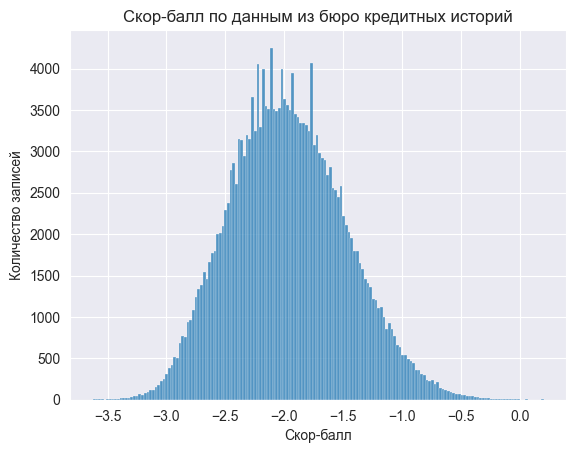

In [19]:
sns.histplot(application_data["Score_bki"])
plt.title("Скор-балл по данным из бюро кредитных историй")
plt.ylabel("Количество записей")
plt.xlabel("Скор-балл")
plt.show()

12. `out_request_cnt` - Количество запросов в бюро
<br>Проверим распределение значений данного признака

In [20]:
application_data["out_request_cnt"].value_counts().to_frame()

,count
out_request_cnt,
1,50979
0,50621
2,39915
3,26884
4,16149
5,9197
6,4730
7,2458
8,1283


13. `region_rating` - Рейтинг региона
<br>Проверим распределение значений данного признака

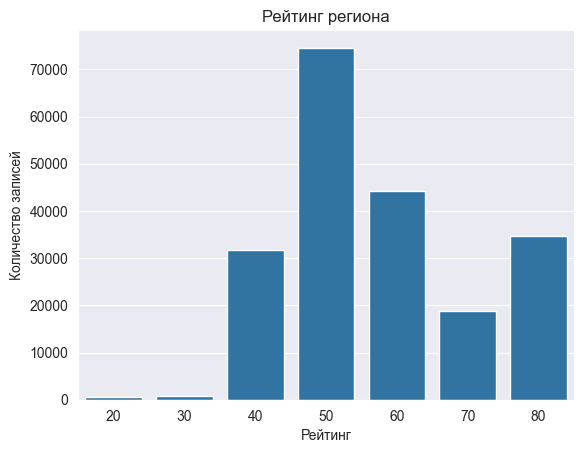

In [23]:
sns.barplot(application_data["region_rating"].value_counts())
plt.title("Рейтинг региона")
plt.ylabel("Количество записей")
plt.xlabel("Рейтинг")
plt.show()

14. `home_address_cd` - Категоризатор домашнего адреса
<br>Проверим распределение значений данного признака

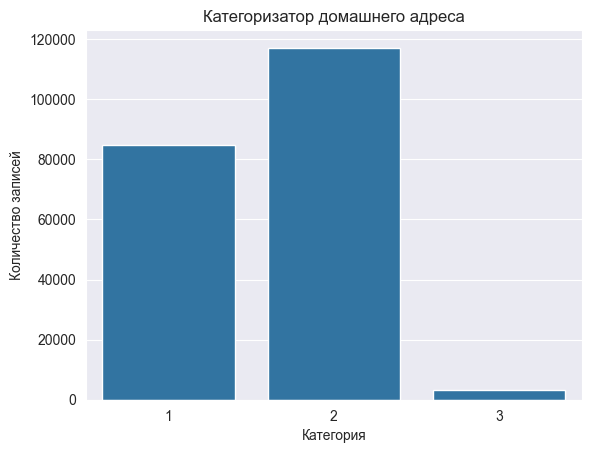

In [25]:
sns.barplot(application_data["home_address_cd"].value_counts())
plt.title("Категоризатор домашнего адреса")
plt.ylabel("Количество записей")
plt.xlabel("Категория")
plt.show()

15. `work_address_cd` - Категоризатор рабочего адреса
<br>Проверим распределение значений данного признака

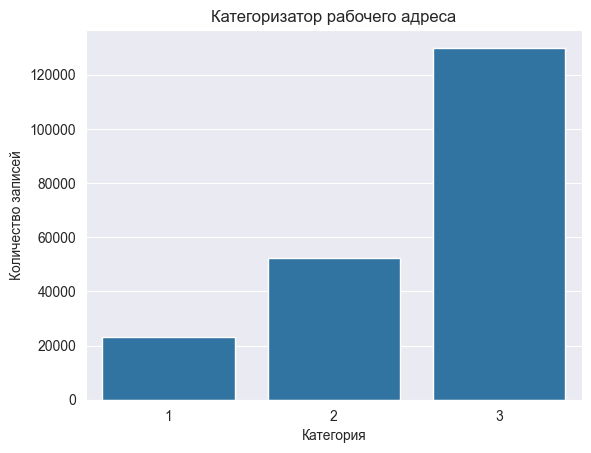

In [26]:
sns.barplot(application_data["work_address_cd"].value_counts())
plt.title("Категоризатор рабочего адреса")
plt.ylabel("Количество записей")
plt.xlabel("Категория")
plt.show()

16. `income` - Доход заявителя
<br>Проверим распределение значений данного признака

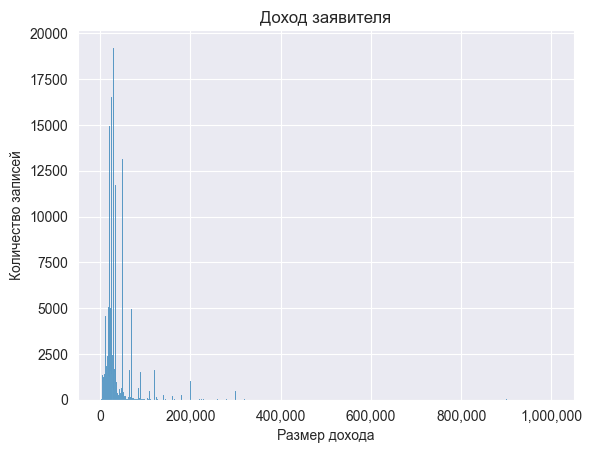

In [ ]:
import matplotlib.ticker as ticker

ax = sns.histplot(application_data["income"])
ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f"{int(x):,}"))
plt.title("Доход заявителя")
plt.ylabel("Количество записей")
plt.xlabel("Размер дохода")
plt.show()

17. `SNA` - Связь заявителя с клиентами
<br>Проверим распределение значений данного признака

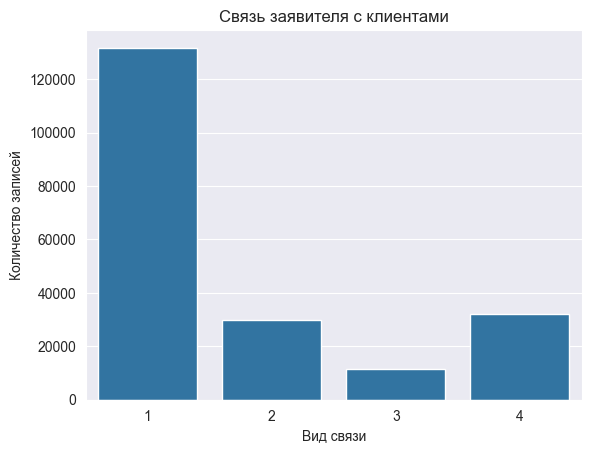

In [33]:
sns.barplot(application_data["SNA"].value_counts())
plt.title("Связь заявителя с клиентами")
plt.ylabel("Количество записей")
plt.xlabel("Вид связи")
plt.show()

18. `first_time_cd` - Давность наличия информации о заявителе
<br>Проверим распределение значений данного признака

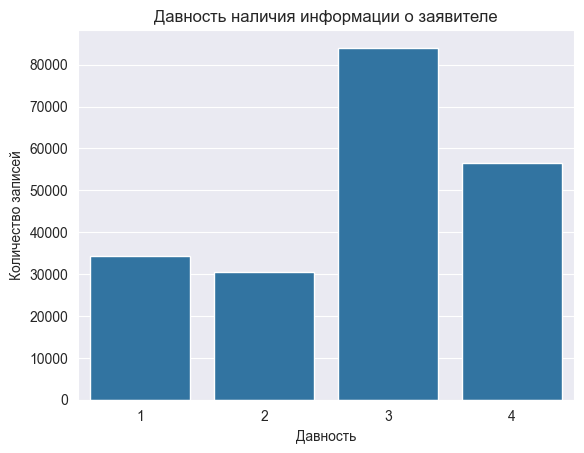

In [42]:
sns.barplot(application_data["first_time_cd"].value_counts())
plt.title("Давность наличия информации о заявителе")
plt.ylabel("Количество записей")
plt.xlabel("Давность")
plt.show()

19. `Air_flg` - Наличие загран паспорта
<br>Проверим распределение значений данного признака

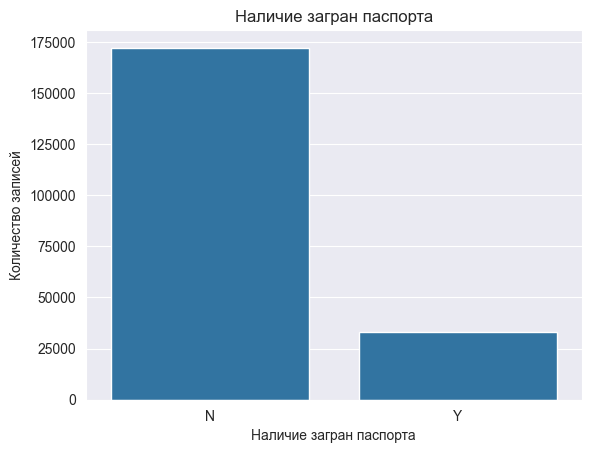

In [44]:
sns.barplot(application_data["Air_flg"].value_counts())
plt.title("Наличие загран паспорта")
plt.ylabel("Количество записей")
plt.xlabel("Наличие загран паспорта")
plt.show()

### Исследование `default_data`
Теперь рассмотрим таблицу меток о дефолте клиентов

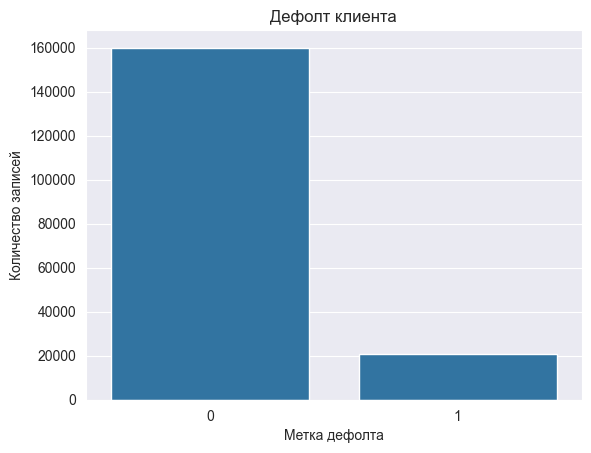

In [50]:
sns.barplot(default_data["default_flg"].value_counts())
plt.title("Дефолт клиента")
plt.ylabel("Количество записей")
plt.xlabel("Метка дефолта")
plt.show()

In [56]:
is_defaults = default_data[default_data.default_flg == 1].count()
percent_of_defaults = is_defaults / default_data.count() * 100
print(f"Доля дефолтов составляет {percent_of_defaults.item():.1f}%")

Доля дефолтов составляет 11.5%


Как видно из графика и процента выше, мы имеем сильный дисбаланс классов: 11.5 процентов дефолтов и 88.5 процентов платежеспособных клиентов. Учтем этот дисбаланс при построении модели.

## 4. Подготовка данных
Приступим к подготовке данных для обучения и валидации